# ML modelling ใช้ค่า corr ที่ดีที่สุดรายชั่วโมง
* ทดสอบ 5 แบบจำลอง ได้แก่ RandomForestRegressor, GradientBoostingRegressor, LinearRegression, DecisionTreeRegressor, xgboost
* ประเมินด้วยสถิติ RMSE, MSE, MAE, MFB, Correlation Coefficient, R2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from scipy.stats import uniform, randint, linregress
import xgboost as xgb

import geopandas as gpd

warnings.filterwarnings('ignore')



## Read and cleansing data

In [2]:
df = pd.read_csv('./00Results/00rain_radar_hourly_extracted_all_events_mean_dBZ/df_org_dbz_rain_test120km.csv')
df.drop(df[df['rain_x'] <= 0].index, inplace = True) # ทดสอบการตัดฝนอ่อนตรงนี้้ได 0, 0.5,1.0
#df.drop(df[df['rain_x'] < 1.0].index, inplace = True) # ทดสอบการตัดฝนอ่อนตรงนี้้ได 0, 0.5,1.0
#df.drop(df[df['cappi1km'] < 10].index, inplace = True) #ฝนอ่่อนมากๆ < 10 dBZ
#df.drop(df[df['cappi4km'] > 55].index, inplace = True) #ค่าการสะท้อนที่อาจเป็นลูกเห็บ 55 dBZ มุมยกด้านบนสุด
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
#df.reset_index(drop=True)
#df.dropna(inplace=True)

In [3]:
df.rename(columns={"cappi1km": "dBZ_c1", "cappi2km": "dBZ_c2","cappi3km": "dBZ_c3","cappi4km": "dBZ_c4"}, inplace=True)
df.rename(columns={"rain_x":"rain_truth"}, inplace=True)
df

,dBZ_c1,dBZ_c2,dBZ_c3,dBZ_c4,full_date,code,rain_truth
6,NaN,NaN,NaN,NaN,2018-06-01-00:00,CTKN,10.8
28,NaN,NaN,NaN,NaN,2018-06-01-00:00,NMPR,3.6
72,22.267728,22.656334,23.252944,23.492632,2018-06-01-01:00,CMSG,0.4
107,37.450751,35.934908,34.647741,31.643592,2018-06-01-01:00,PIN004,0.2
138,28.847841,28.025389,26.520176,24.078056,2018-06-01-02:00,CMSG,0.2
...,...,...,...,...,...,...,...
68305,NaN,NaN,NaN,NaN,2018-09-21-18:00,CNDN,0.4
68328,NaN,NaN,NaN,NaN,2018-09-21-18:00,NAN005,1.0
68334,18.423027,18.423027,18.423027,NaN,2018-09-21-18:00,NGBA,0.8
68411,29.833809,NaN,NaN,NaN,2018-09-21-19:00,NAN013,24.8


### คำนวณฝนประมาณค่าจากเรดาร์ค่าด้วย ZR Vectorized Operations:

In [4]:
#  Vectorized Operations:
constants = {
    'MP': (200, 1.6), # ZR marshall/palmer
    'RF': (250, 1.2), # ZR Rosenfeld
    'SC': (300, 1.4) # ZR Summer Deep Convection
}

for prefix, (a, b) in constants.items():
    for suffix in ['c1', 'c2', 'c3', 'c4']:
        dBZ_column = f'dBZ_{suffix}'
        rr_column = f'rr_{prefix}_{suffix}'
        df[rr_column] = ((10**(df[dBZ_column]/10.))/a)**(1/b)

In [5]:
#### ดรอปคอมลัมน์ cappi ทิ้ง
df.drop(columns=['dBZ_c1','dBZ_c2','dBZ_c3','dBZ_c4'], inplace=True) #ลบคอลัน์
df

,full_date,code,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
6,2018-06-01-00:00,CTKN,10.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,2018-06-01-00:00,NMPR,3.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,2018-06-01-01:00,CMSG,0.4,0.898647,0.950336,1.035536,1.071879,0.720047,0.775791,0.869885,0.910827,0.662491,0.706216,0.779027,0.810350
107,2018-06-01-01:00,PIN004,0.2,7.989658,6.423741,5.337527,3.464023,13.262108,9.914991,7.745125,4.351938,8.047877,6.272011,5.075354,3.096594
138,2018-06-01-02:00,CMSG,0.2,2.316575,2.057989,1.657171,1.166097,2.545092,2.173530,1.628288,1.019111,1.955185,1.707816,1.333294,0.892255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68305,2018-09-21-18:00,CNDN,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68328,2018-09-21-18:00,NAN005,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68334,2018-09-21-18:00,NGBA,0.8,0.516768,0.516768,0.516768,NaN,0.344325,0.344325,0.344325,NaN,0.352013,0.352013,0.352013,NaN
68411,2018-09-21-19:00,NAN013,24.8,2.669742,NaN,NaN,NaN,3.075158,NaN,NaN,NaN,2.299397,NaN,NaN,NaN


In [6]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [7]:
df

,full_date,code,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
0,2018-06-01-01:00,CMSG,0.4,0.898647,0.950336,1.035536,1.071879,0.720047,0.775791,0.869885,0.910827,0.662491,0.706216,0.779027,0.810350
1,2018-06-01-01:00,PIN004,0.2,7.989658,6.423741,5.337527,3.464023,13.262108,9.914991,7.745125,4.351938,8.047877,6.272011,5.075354,3.096594
2,2018-06-01-02:00,CMSG,0.2,2.316575,2.057989,1.657171,1.166097,2.545092,2.173530,1.628288,1.019111,1.955185,1.707816,1.333294,0.892255
3,2018-06-01-02:00,NSRS,2.8,26.740589,25.118143,21.500539,16.534742,66.395140,61.078967,49.641029,34.976114,32.009071,29.799314,24.947083,18.478841
4,2018-06-01-03:00,CMSG,0.2,5.971266,4.801238,4.734323,5.353180,8.994911,6.725314,6.600631,7.775424,5.769704,4.496865,4.425311,5.092368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2601,2018-09-20-16:00,TGSK,0.8,0.871279,1.291773,1.794893,1.963920,0.690957,1.168127,1.811173,2.042083,0.639483,1.002976,1.460664,1.618897
2602,2018-09-20-17:00,PAS003,2.6,7.637749,6.846747,5.652252,4.423040,12.489034,10.794950,8.359949,6.028410,7.644055,6.746207,5.418789,4.094371
2603,2018-09-20-17:00,TGSK,0.2,0.816687,1.046085,1.194923,1.347858,0.633844,0.881721,1.052838,1.236234,0.593899,0.788103,0.917506,1.052896
2604,2018-09-21-14:00,PIN003,2.4,3.570917,3.593265,3.415970,2.660618,4.531911,4.569766,4.271631,3.061153,3.206039,3.228980,3.047550,2.290418


## Feature analysis

###  Correlation matrix analysis:

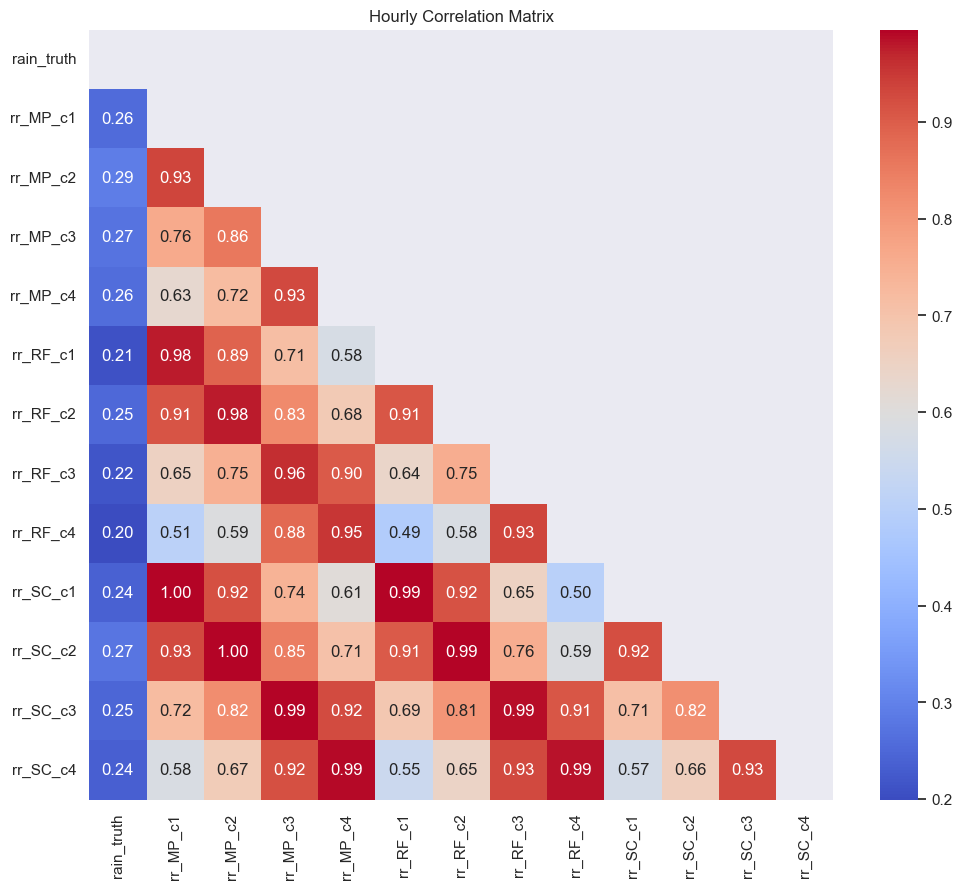

important_features_corr: ['rain_truth', 'rr_MP_c2', 'rr_SC_c2', 'rr_MP_c3', 'rr_MP_c4', 'rr_MP_c1', 'rr_RF_c2', 'rr_SC_c3', 'rr_SC_c1', 'rr_SC_c4', 'rr_RF_c3', 'rr_RF_c1']


In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.corr()

# Create a mask for the lower triangular part
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set the font scale for the heatmap
sns.set(font_scale=1.0)  # Adjust the font scale as needed

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title("Hourly Correlation Matrix")
plt.show()

# Identify features highly correlated with the target
correlation_with_target = correlation_matrix['rain_truth'].abs().sort_values(ascending=False)
important_features_corr = correlation_with_target[correlation_with_target > 0.20].index.tolist()
print('important_features_corr:', important_features_corr)


### เตรียมข้อมูล

In [9]:
# แยกข้อมูล
from sklearn.model_selection import train_test_split
TargetVariable=['rain_truth']
#Predictors=['rr_RF_c1', 'dBZ_p1', 'rr_SC_c1', 'rr_RF_p1', 'dBZ_c1', 'rr_MP_c1']
#Predictors=['dBZ_c1', 'dBZ_c2', 'dBZ_c3', 'dBZ_c4']
Predictors=['rr_SC_c1','rr_SC_c2','rr_SC_c3','rr_SC_c4']

X=df[Predictors].values
y=df[TargetVariable].values

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 1824 rows
Test Set: 782 rows


## การทดสอบแบบจำลอง ML

### สถิติประเมินแบบจำลอง

In [10]:
def cal_metrics(x, y):    
    rmse = np.sqrt(mean_squared_error(x, y))
    mse = mean_squared_error(x, y)
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)
    mfb = x.sum(axis=0) / y.sum(axis=0)
    
    # Calculate p-value and correlation coefficient (r)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    return {
        "RMSE": rmse,
        "MSE": mse,
        "MAE": mae,
        "R-squared": r2,
        "MFB": mfb,
        "Correlation coefficient (r)": r_value,
        "P-value": p_value
    }

### ทดสอบกับ GradientBoostingRegressor

In [11]:
# Use a Gradient Boosting algorithm
alg = GradientBoostingRegressor()

# Define the hyperparameter search space
params = {
    'learning_rate': uniform(0.01, 1.0),
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define RMSE as the scoring metric (negative MSE)
score = 'neg_mean_squared_error'
random_search = RandomizedSearchCV(alg, params, n_iter=50, scoring=score, cv=5, random_state=42, return_train_score=True)
random_search.fit(X_train, y_train)

print("Best parameter combination:", random_search.best_params_, "\n")

# Get the best model
best_model_GradientBoostingRegressor = random_search.best_estimator_
print(best_model_GradientBoostingRegressor, "\n")

# Evaluate the model using the test data
predictions_GradientBoostingRegressor = best_model_GradientBoostingRegressor.predict(X_test)

Best parameter combination: {'learning_rate': 0.12005192452767675, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50, 'subsample': 0.8} 

GradientBoostingRegressor(learning_rate=0.12005192452767675, min_samples_leaf=4,
                          min_samples_split=5, n_estimators=50, subsample=0.8) 



In [12]:
print(cal_metrics(y_test.flatten(),predictions_GradientBoostingRegressor))

{'RMSE': 5.2378325367499965, 'MSE': 27.434889683036904, 'MAE': 2.521270832068297, 'R-squared': 0.02521558764789633, 'MFB': 1.1139689636444992, 'Correlation coefficient (r)': 0.2349658757499355, 'P-value': 2.8619563877687288e-11}


### ทดสอบกับ RandomForest

In [13]:
# Use a Random Forest algorithm
alg = RandomForestRegressor()

# Define the hyperparameter search space
params = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'bootstrap': [True, False]
}

# Define RMSE as the scoring metric (negative MSE)
score = 'neg_mean_squared_error'
random_search = RandomizedSearchCV(alg, params, n_iter=50, scoring=score, cv=5, random_state=42, return_train_score=True)
random_search.fit(X_train, y_train)

print("Best parameter combination:", random_search.best_params_, "\n")

# Get the best model
best_model_RandomForestRegressor = random_search.best_estimator_
print(best_model_RandomForestRegressor, "\n")

# Evaluate the model using the test data
predictions_RandomForestRegressor = best_model_RandomForestRegressor.predict(X_test)

Best parameter combination: {'bootstrap': True, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 108} 

RandomForestRegressor(max_depth=3, min_samples_leaf=3, min_samples_split=3,
                      n_estimators=108) 



In [14]:
print(cal_metrics(y_test.flatten(),predictions_RandomForestRegressor))

{'RMSE': 5.088022568831515, 'MSE': 25.887973660938847, 'MAE': 2.430485015462732, 'R-squared': 0.0801787984710568, 'MFB': 1.1244352627838001, 'Correlation coefficient (r)': 0.2904310349091929, 'P-value': 1.1517228511148622e-16}


### ทดสอบกับ Decision Tree

In [15]:
# Use a Decision Tree algorithm
alg = DecisionTreeRegressor()

# Define the hyperparameter search space
params = {
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'splitter': ['best', 'random']
}

# Define RMSE as the scoring metric (negative MSE)
score = 'neg_mean_squared_error'
random_search = RandomizedSearchCV(alg, params, n_iter=50, scoring=score, cv=5, random_state=42, return_train_score=True)
random_search.fit(X_train, y_train)

print("Best parameter combination:", random_search.best_params_, "\n")

# Get the best model
best_model_DecisionTreeRegressor = random_search.best_estimator_
print(best_model_DecisionTreeRegressor, "\n")

# Evaluate the model using the test data
predictions_DecisionTreeRegressor = best_model_DecisionTreeRegressor.predict(X_test)

Best parameter combination: {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 6, 'splitter': 'random'} 

DecisionTreeRegressor(max_depth=4, min_samples_leaf=2, min_samples_split=6,
                      splitter='random') 



In [16]:
print(cal_metrics(y_test.flatten(),predictions_DecisionTreeRegressor))

{'RMSE': 5.065083908739125, 'MSE': 25.65507500256802, 'MAE': 2.4344509879393166, 'R-squared': 0.08845388120186037, 'MFB': 1.1219187473544363, 'Correlation coefficient (r)': 0.3024671016599552, 'P-value': 5.235925713947001e-18}


### ทดสอบกับ Linear Regression

In [17]:
# Use a Linear Regression algorithm
alg = LinearRegression()

# Define the hyperparameter search space
params = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False],
    'n_jobs': [-1, 1]
}

# Define RMSE as the scoring metric (negative MSE)
score = 'neg_mean_squared_error'
random_search = RandomizedSearchCV(alg, params, n_iter=50, scoring=score, cv=5, random_state=42, return_train_score=True)
random_search.fit(X_train, y_train)

print("Best parameter combination:", random_search.best_params_, "\n")

# Get the best model
best_model_LinearRegression = random_search.best_estimator_
print(best_model_LinearRegression, "\n")

# Evaluate the model using the test data
predictions_LinearRegression = best_model_LinearRegression.predict(X_test)

Best parameter combination: {'normalize': True, 'n_jobs': -1, 'fit_intercept': True, 'copy_X': True} 

LinearRegression(n_jobs=-1, normalize=True) 



In [18]:
print(cal_metrics(y_test.flatten(),predictions_LinearRegression.flatten()))

{'RMSE': 5.122356265904266, 'MSE': 26.238533714848696, 'MAE': 2.5234222838937677, 'R-squared': 0.06772310865080866, 'MFB': 1.1317943572449052, 'Correlation coefficient (r)': 0.26805729563960684, 'P-value': 2.45952855988003e-14}


### xgboost

In [19]:
# Use XGBoost algorithm
xgb_model = xgb.XGBRegressor()

# Define the hyperparameter search space
params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_lambda': [0, 1, 10]
}

# Use RandomizedSearchCV or GridSearchCV for hyperparameter tuning
# RandomizedSearchCV example
from sklearn.model_selection import RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(xgb_model, params, n_iter=50, scoring='r2', cv=5, random_state=42, return_train_score=True)
random_search_xgb.fit(X_train, y_train)

print("Best parameter combination:", random_search_xgb.best_params_, "\n")

# Get the best model
best_xgb_model = random_search_xgb.best_estimator_
print(best_xgb_model, "\n")

# Evaluate the model using the test data
predictions_xgb = best_xgb_model.predict(X_test)

Best parameter combination: {'subsample': 0.9, 'reg_lambda': 10, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8} 

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.1, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...) 



In [20]:
print(cal_metrics(y_test.flatten(),predictions_xgb.flatten()))

{'RMSE': 5.13345093077302, 'MSE': 26.352318458654388, 'MAE': 2.348944541987251, 'R-squared': 0.06368024221661817, 'MFB': 1.2836845300896642, 'Correlation coefficient (r)': 0.27382536823542286, 'P-value': 6.4648148150738154e-15}


## ประเมินแบบจำลองจากค่าสถิติ

In [21]:
# Evaluate the models using the test data
predictions = {
    "GradientBoostingRegressor": best_model_GradientBoostingRegressor.predict(X_test),
    "RandomForestRegressor": best_model_RandomForestRegressor.predict(X_test),
    "DecisionTreeRegressor": best_model_DecisionTreeRegressor.predict(X_test),
    "LinearRegression": best_model_LinearRegression.predict(X_test),
    "XGBoost": best_xgb_model.predict(X_test)
}

# Calculate metrics for each model
metrics = {}
for model_name, prediction in predictions.items():
    metrics[model_name] = cal_metrics(y_test.flatten(), prediction.flatten())

# Create DataFrames from metrics dictionaries
dfs = []
for model_name, metric in metrics.items():
    dfs.append(pd.DataFrame(metric, index=[0]))

# Concatenate DataFrames along the rows
results_df = pd.concat(dfs, ignore_index=True)

# Add Model names
results_df['Model'] = list(predictions.keys())

# Set the display format to 3 decimal places
pd.options.display.float_format = '{:.3f}'.format

# Print the results
print(results_df)
results_df

   RMSE    MSE   MAE  R-squared   MFB  Correlation coefficient (r)  P-value  \
0 5.238 27.435 2.521      0.025 1.114                        0.235    0.000   
1 5.088 25.888 2.430      0.080 1.124                        0.290    0.000   
2 5.065 25.655 2.434      0.088 1.122                        0.302    0.000   
3 5.122 26.239 2.523      0.068 1.132                        0.268    0.000   
4 5.133 26.352 2.349      0.064 1.284                        0.274    0.000   

                       Model  
0  GradientBoostingRegressor  
1      RandomForestRegressor  
2      DecisionTreeRegressor  
3           LinearRegression  
4                    XGBoost  


,RMSE,MSE,MAE,R-squared,MFB,Correlation coefficient (r),P-value,Model
0,5.238,27.435,2.521,0.025,1.114,0.235,0.000,GradientBoostingRegressor
1,5.088,25.888,2.430,0.080,1.124,0.290,0.000,RandomForestRegressor
2,5.065,25.655,2.434,0.088,1.122,0.302,0.000,DecisionTreeRegressor
3,5.122,26.239,2.523,0.068,1.132,0.268,0.000,LinearRegression
4,5.133,26.352,2.349,0.064,1.284,0.274,0.000,XGBoost


### พลอตกราฟสถิติผลลัพธ์แบบจำลอง

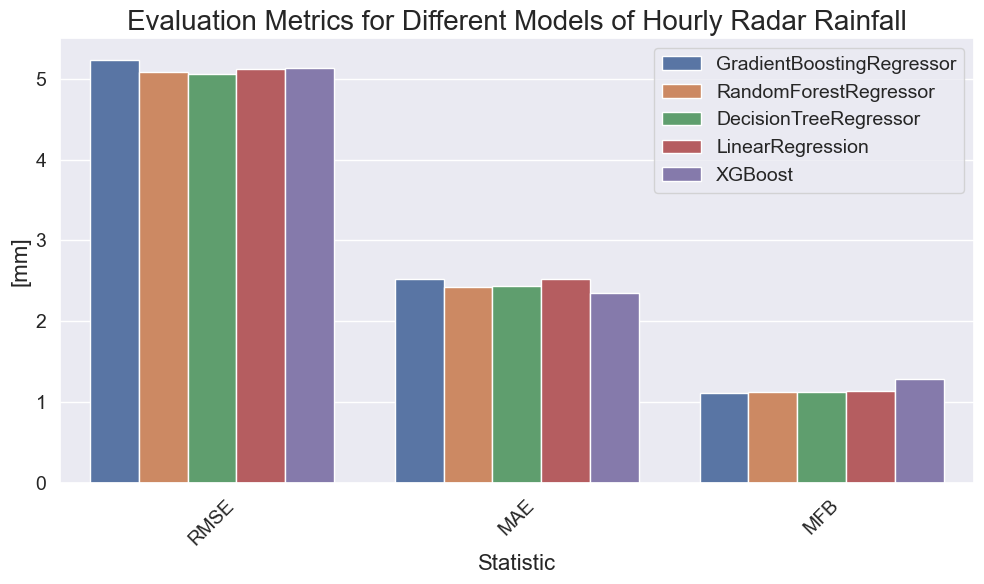

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out the columns you don't want to include in the plot
columns_to_exclude = ['P-value', 'R-squared', 'MSE', 'Correlation coefficient (r)']
results_df_filtered = results_df.drop(columns=columns_to_exclude)

# Melt the DataFrame to make it suitable for plotting
melted_df = results_df_filtered.melt(id_vars=['Model'], var_name='Statistic', value_name='Value')

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=melted_df, x='Statistic', y='Value', hue='Model')
plt.title('Evaluation Metrics for Different Models of Hourly Radar Rainfall', fontsize=20)  # Increase title font size
plt.xlabel('Statistic', fontsize=16)  # Increase x-axis label font size
plt.ylabel('[mm]', fontsize=16)  # Increase y-axis label font size
plt.xticks(rotation=45, fontsize=14)  # Increase x-axis tick font size and rotate labels
plt.yticks(fontsize=14)  # Increase y-axis tick font size

# Increase legend font size and legend title font size
plt.legend(fontsize=14, title_fontsize=16)

plt.tight_layout()
plt.show()



### density plot

In [23]:
def density_plot(rain_truth, rain_radar, max_=15):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde
    from scipy.stats import linregress
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    

    font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 22}

    plt.rc('font', **font)

    
    SMALL_SIZE = 12
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 16

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    # data
    x = rain_radar
    y = rain_truth

    # Calculate the point density
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    # Set the desired colorbar range
    cbar_min = 0.005  # specify your minimum value
    cbar_max = 0.050 # specify your maximum value

    # Create scatter plot with density color map
    fig, ax = plt.subplots()
    scatter = ax.scatter(x, y, c=z, s=40, cmap='rainbow', alpha=0.6, vmin=cbar_min, vmax=cbar_max)

    # Set x and y axis limits
    plt.xlim(0, max_)
    plt.ylim(0, max_)

    # Plot the 1:1 line
    plt.plot([0, max_], [0, max_], linestyle='--', color='grey', linewidth=2)

    # Set font size for axis labels and title
    plt.xlabel('predicted radar rainfall based on model [mm]')
    plt.ylabel('gauge rainfall [mm]')
    plt.title('Comparison hourly radar and gauge rainfall', fontsize=16)

    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Density', fontsize=14)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(x, y))
    mse = mean_squared_error(x, y)
    mae = mean_absolute_error(x, y)
    r2 = r2_score(x, y)

    # Calculate p-value and correlation coefficient (r)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Plot the regression line
    #plt.plot(x, slope * x + intercept, linestyle='-', color='magenta', linewidth=2,
    #         label=f'Regression Line (r={r_value:.2f}, p={p_value:.4f})')
    
    # Set font size for legend
    plt.legend(fontsize=12)

    # Display the plot
    plt.show()
    
    print(slope, intercept)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


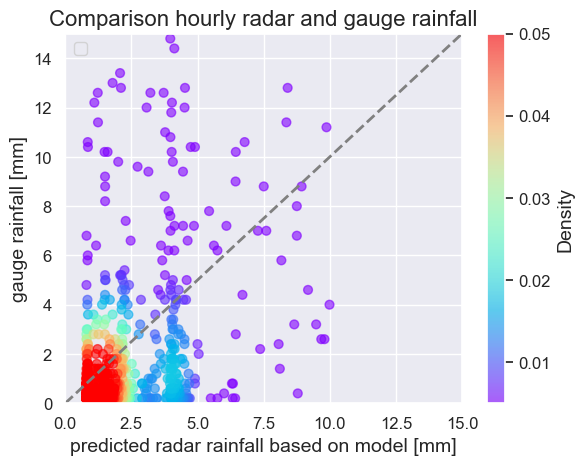

0.888006792994892 0.5362005726223011


In [24]:
density_plot(y_test.flatten(),best_model_RandomForestRegressor.predict(X_test), 15)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


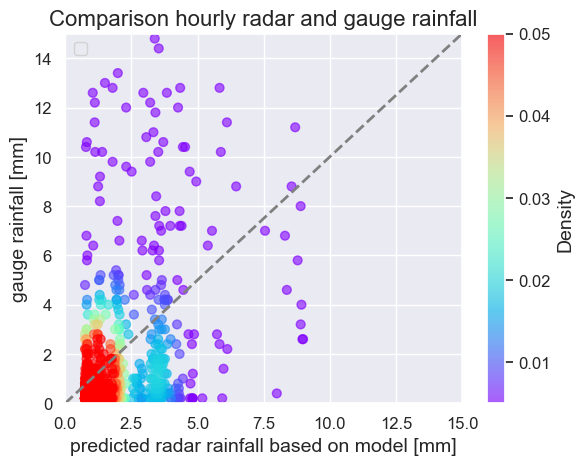

0.9858054796433016 0.5917574600752731


In [25]:
density_plot(y_test.flatten(),best_xgb_model.predict(X_test), 15)

## ตัดสินใจว่าแบบจำลองไหนที่ดีที่สุด 
* ด้วยการให้ค่าคะแนนจากค่าสถิติที่ใช้วัด ในที่นี้ใช้ 5 ตัว คือ RMSE, MSE, MAE, MFB,Correlation coefficient ด้วยการกำหนดค่าน้ำหนักของสถิติเท่ากัน คือ 0.2
* แต่ค่า RMSE, MSE, MAE, MFB ต้องนำไปถ่วงน้ำหนักก่อน เนื่องจากค่าเหล่านี้ ค่าน้อย คือ ค่าที่ดี ดังนั้นต้อง inverse ค่าก่อนนำไปถ่วงค่าน้ำหนักเพื่อหาคะแนน
* คำเตือน ห้ามรันค่าการถ่วงน้ำหนักต่อกัน เพราะจะทำให้มีซ้อนทับค่าตัวแปร แม้ว่าจะแบ็คอัพไว้แล้ว

### ทดสอบให้ค่าน้ำหนัก

In [26]:
# ดัดแปลงค่า ก่อนนำไปถ่วงน้ำหนัก
# Define weights for each metric
weights = {
    'RMSE': 0,
    'MSE': 0,
    'MAE': 0,
    'MFB': 0.5, #เน้น
    'Correlation coefficient (r)': 0.5 #เน้น
}

# Define a list of columns to be modified value before applying weithing score เพราะว่าค่า เหล่านี้ยิ่งมากยิ่งไม่ดี เลยต้อง inverse
columns_to_modify = ['RMSE', 'MSE', 'MAE', 'MFB']

# Apply the transformation to each column
for column in columns_to_modify:
    results_df[column] = (results_df[column].max() + 1) - results_df[column]

# Define a function to calculate weighted score
def calculate_weighted_score(row):
    weighted_sum = sum(row[metric] * weights[metric] for metric in weights.keys())
    return weighted_sum

# Calculate the weighted score for each model
results_df['Weighted Score'] = results_df.apply(calculate_weighted_score, axis=1)

# Normalize the weighted scores to ensure the sum equals 1.0
results_df['Weighted Score'] /= results_df['Weighted Score'].sum()

# Find the model with the highest normalized weighted score
best_model = results_df.loc[results_df['Weighted Score'].idxmax()]

# Print the results
print("Weighted Scores:")
print(results_df[['Model', 'Weighted Score']])

print("\nBest Model:")
print(best_model)



Weighted Scores:
                       Model  Weighted Score
0  GradientBoostingRegressor           0.200
1      RandomForestRegressor           0.207
2      DecisionTreeRegressor           0.209
3           LinearRegression           0.202
4                    XGBoost           0.182

Best Model:
RMSE                                           1.173
MSE                                            2.780
MAE                                            1.089
R-squared                                      0.088
MFB                                            1.162
Correlation coefficient (r)                    0.302
P-value                                        0.000
Model                          DecisionTreeRegressor
Weighted Score                                 0.209
Name: 2, dtype: object
